In [ ]:
import numpy as np
from icecream import ic
import matplotlib.pyplot as plt
import numpy as np
import torch
import os
import shutil
import pandas as pd
import random
from datetime import datetime
from scipy.interpolate import UnivariateSpline

In [ ]:
print(torch.cuda.is_available())
print(torch.cuda.get_device_name(0))


True
NVIDIA GeForce RTX 3050 Laptop GPU


In [ ]:
torch.manual_seed(3456)
torch.cuda.manual_seed_all(3456)
numOfparticles=10000
a=torch.arange(0,numOfparticles,1)
length=2000
r=(torch.rand(device="cuda",size=(numOfparticles,2))-0.5)*2*length
ids=torch.arange(0,numOfparticles,device="cuda",)
vels=torch.zeros_like(r,device="cuda",)
inivel=500
radius=0.7
dt=0.01
time=25
binNumber=700
mass=1e-24

In [ ]:
tracked=random.sample(range(numOfparticles),4)
totalTracker=[[],[],[],[]]
energy=[]
entropy=[]
temperature=[]

In [ ]:

leftParticles=r[:,0]<=0
rightParticles=r[:,0]>0
vels[leftParticles,0]=inivel
vels[rightParticles,0]=- inivel
vels=vels+torch.rand_like(vels,device="cuda",)
m=1
k=1


In [ ]:
path=f"{length}L,{numOfparticles}N,r{radius},{time}t/Data/"
if(not(os.path.exists(path))):
    os.makedirs(path)

else:
    shutil.rmtree(path)
    os.makedirs(path)

In [ ]:

allCombidx = torch.combinations(ids, 2).to("cuda")
def Collpairsfunc(r):
    combPosition=r[allCombidx]
    p1=combPosition[:,0]
    p2=combPosition[:,1]
    combDistance= torch.linalg.norm(p1-p2,dim=1)
    isCollision=combDistance<=2*radius
    collPairs=allCombidx[isCollision]
    return collPairs

collPairs=Collpairsfunc(r=r)
print(collPairs.shape)


torch.Size([17, 2])


In [ ]:
def newVelocity(vels,r):
    collPairs=Collpairsfunc(r)
    for pair in collPairs:
        m1=pair[0]
        m2=pair[1]
        v1=vels[m1,:]
        r1=r[m1,:]
        v2=vels[m2,:]
        r2=r[m2,:]
        relPos=r1-r2+1e-10
        magrelPos=torch.dot(relPos,relPos)
        relVels=v1-v2
        vdr=torch.dot(r1-r2,relVels)
        v1Dash= v1- vdr/(magrelPos)*(relPos)
        v2Dash=v2+vdr/(magrelPos)*(relPos)
        vels[m1,:]=v1Dash
        vels[m2,:]=v2Dash
    return vels

In [ ]:
def update(r,vels,dt=dt):
    r=r+(vels*dt) #type:ignore
    xRight=r[:,0]> length
    xLeft=r[:,0]< -length
    yTop=r[:,1]> length
    yBottom=r[:,1]< -length
    vels[xRight,0] *= -1
    vels[xLeft,0]  *= -1
    vels[yBottom,1]   *= -1
    vels[yTop,1]*= -1
    r[xRight,0] = 2*length- r[xRight,0]
    r[xLeft,0] = -2*length- r[xLeft,0]
    r[yTop,1]  = 2*length- r[yTop,1]
    r[yBottom,1] = -2*length- r[yBottom,1]
    vels = newVelocity(vels, r)
    for i in range(len(tracked)):
        totalTracker[i].append(r[tracked[i]].cpu().numpy())
    return r,vels


In [ ]:
nowTime=0


def energyEntropyTemp(nowTime,magvels,magvelsnp):
    E_t=1/2*torch.sum(magvels*magvels)*1e-18
    energy.append([nowTime,E_t.item()])
    speednp=magvelsnp
    hist, bins= np.histogram(speednp,bins=12000,density=True,range=(0,3000))
    binwidth=bins[1]-bins[0]
    p=binwidth*hist+1e-10
    S=-np.sum(p*np.log(p))
    entropy.append([nowTime,S])
    T=np.mean(speednp**2)/2/130
    temperature.append([nowTime,T])
    return 0


while(nowTime<=time):
    magvels = torch.norm(vels, dim=1)
    magvelsnp = magvels.detach().cpu().numpy()
    energyEntropyTemp(nowTime=nowTime,magvels=magvels,magvelsnp=magvelsnp)
    r,vels=update(r,vels)
    nowTime=round(nowTime+dt,2)


numvels=magvelsnp #type:ignore

In [ ]:
p1, p2, p3, p4 = np.array(totalTracker)

dfEntropy=pd.DataFrame({
    "Time":np.array(entropy)[:,0],
    "Entropy":np.array(entropy)[:,1]
})

posTrack = pd.DataFrame({
    "p1_x": p1[:,0], "p1_y": p1[:,1],
    "p2_x": p2[:,0], "p2_y": p2[:,1],
    "p3_x": p3[:,0], "p3_y": p3[:,1],
    "p4_x": p4[:,0], "p4_y": p4[:,1],
})

dfTemperature=pd.DataFrame({
    "Time":np.array(temperature)[:,0],
    "Temperature":np.array(temperature)[:,1]
})

dfEnergy=pd.DataFrame({
    "Time":np.array(energy)[:,0],
    "Energy":np.array(energy)[:,1]
})

dfTemperature.to_csv(f"{path}Temperature.csv")
dfEntropy.to_csv(f"{path}Entropy.csv")
dfEnergy.to_csv(f"{path}Energy.csv")
posTrack.to_csv(f"{path}Trajectories particles.csv", index=False)

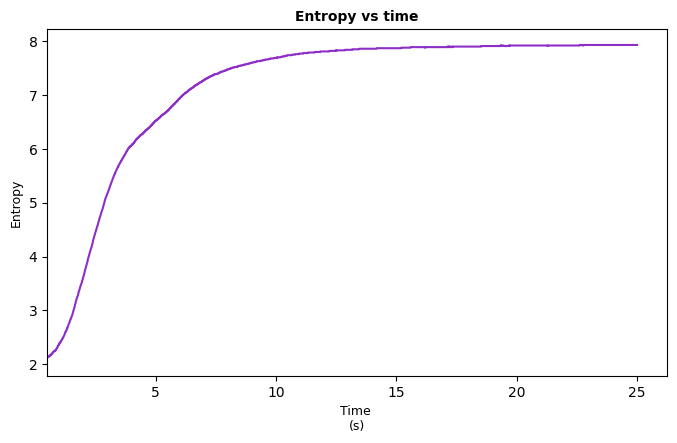

In [ ]:
plt.figure(figsize=(8,4.5))
entropyDF=pd.read_csv(f"{path}Entropy.csv")
plt.plot(round(entropyDF["Time"],2),round(entropyDF["Entropy"],2),color="#8E2EC7")
plt.title("Entropy vs time",fontdict=dict(fontweight="bold",fontsize=10))
plt.ylabel("Entropy",fontdict=dict(fontsize=9))
plt.xlabel("Time \n(s)",fontdict=dict(fontsize=9))
plt.show()

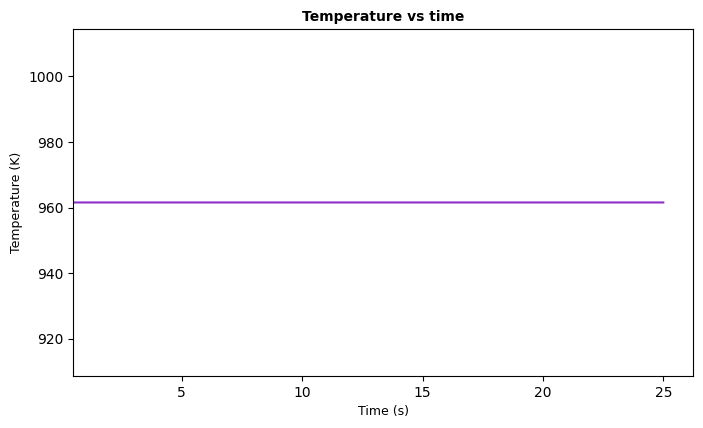

In [ ]:
plt.figure(figsize=(8,4.5))
TempDF=pd.read_csv(f"{path}Temperature.csv")
plt.plot(round(TempDF["Time"],2),round(TempDF["Temperature"],2),color="#8E2EC7")
plt.title("Temperature vs time",fontdict=dict(fontweight="bold",fontsize=10))
plt.ylabel("Temperature (K)",fontdict=dict(fontsize=9))
plt.xlabel("Time (s)",fontdict=dict(fontsize=9))
plt.xlim(0.5)
plt.show()

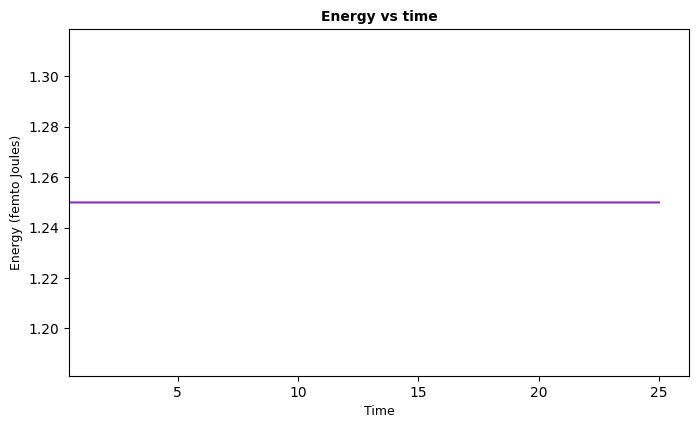

In [ ]:
plt.figure(figsize=(8,4.5))

energyDF=pd.read_csv(f"{path}Energy.csv")
plt.plot(round(energyDF["Time"],2),round(energyDF["Energy"]*1e9,2),color="#8E2EC7")
plt.title("Energy vs time",fontdict=dict(fontweight="bold",fontsize=10))
plt.ylabel("Energy (femto Joules)",fontdict=dict(fontsize=9))
plt.xlabel("Time",fontdict=dict(fontsize=9))
plt.xlim(0.5)
plt.show()

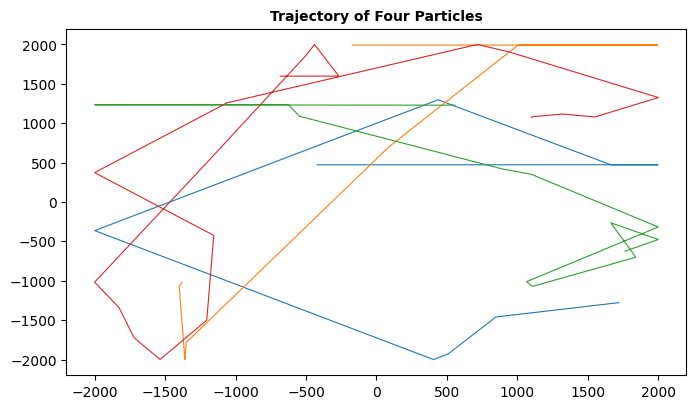

In [ ]:
plt.figure(figsize=(8,4.5))
trajectories=pd.read_csv(f"{path}Trajectories Particles.csv")
p1=pd.DataFrame({"x":trajectories["p1_x"],
                 "y":trajectories["p1_y"]}).to_numpy()
p2=pd.DataFrame({"x":trajectories["p2_x"],
                 "y":trajectories["p2_y"]}).to_numpy()
p3=pd.DataFrame({"x":trajectories["p3_x"],
                 "y":trajectories["p3_y"]}).to_numpy()
p4=pd.DataFrame({"x":trajectories["p4_x"],
                 "y":trajectories["p4_y"]}).to_numpy()
plt.plot(p1[:,0],p1[:,1],linewidth=0.8)
plt.plot(p2[:,0],p2[:,1],linewidth=0.8)
plt.plot(p3[:,0],p3[:,1],linewidth=0.8)
plt.plot(p4[:,0],p4[:,1],linewidth=0.8)
plt.title("Trajectory of Four Particles",fontdict=dict(fontweight="bold",fontsize=10))
plt.show()